In [1]:
from pathlib import Path

import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyvista as pv
from desmin_reconstruction.plotting import line_and_bandplot
from desmin_reconstruction.voronoi import random_uniform_like, VoronoiAnalysis
from tqdm import tqdm


plt.rc("font", size=12)
plt.rc("grid", linestyle="--", color="lightgray")
plt.rc("axes.spines", right=False, top=False)
pv.set_jupyter_backend("static")

datadir = Path("../data/")

## Import and visualize dSTORM raw data

In [2]:
filepath = datadir / "STORM/actin_desmin_600nm.csv"
df = pl.read_csv(filepath)
df = df.with_columns(*[pl.col(i) / 1000 for i in ("x", "y", "z")])
df = df.with_columns(*[pl.col(i) - pl.col(i).min() for i in ("x", "y", "z")])
out = df.partition_by("probe")

Text(0.5, 0.01, 'x (μm)')

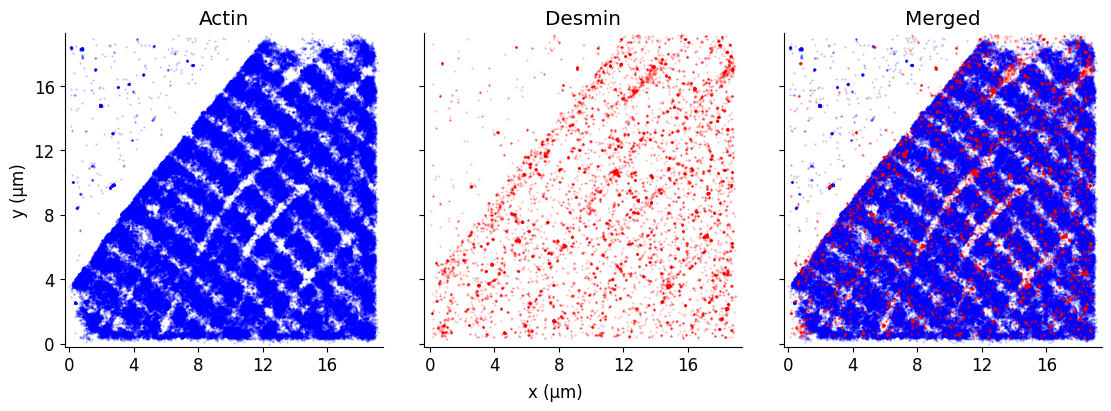

In [3]:
fig, axes = plt.subplots(
    1,
    3,
    figsize=(11, 4),
    sharey=True,
    constrained_layout=True,
    gridspec_kw={"wspace": 0.1},
)
for i in (0, 2):
    axes[i].scatter(
        out[0]["x"],
        out[0]["y"],
        s=0.2,
        c="blue",
        # c=np.log10(out[0]["amp"]),
        # cmap=cc.cm.kr_r,
        alpha=0.3,
    )
for i in (1, 2):
    axes[i].scatter(
        out[1]["x"],
        out[1]["y"],
        s=0.2,
        c="red",
        # c=np.log10(out[1]["amp"]),
        # cmap=cc.cm.kg_r,
        alpha=0.3,
    )

for ax, title in zip(axes, ("Actin", "Desmin", "Merged")):
    ax.axis("equal")
    # ax.set_xlim((-0.2, 19.3))
    ax.set_ylim((-0.2, 19.3))
    ax.set_xticks(np.arange(0, 20, 4))
    ax.set_yticks(np.arange(0, 20, 4))
    ax.set_title(title)
axes[0].set_ylabel("y (μm)")
fig.supxlabel("x (μm)", fontsize="medium")

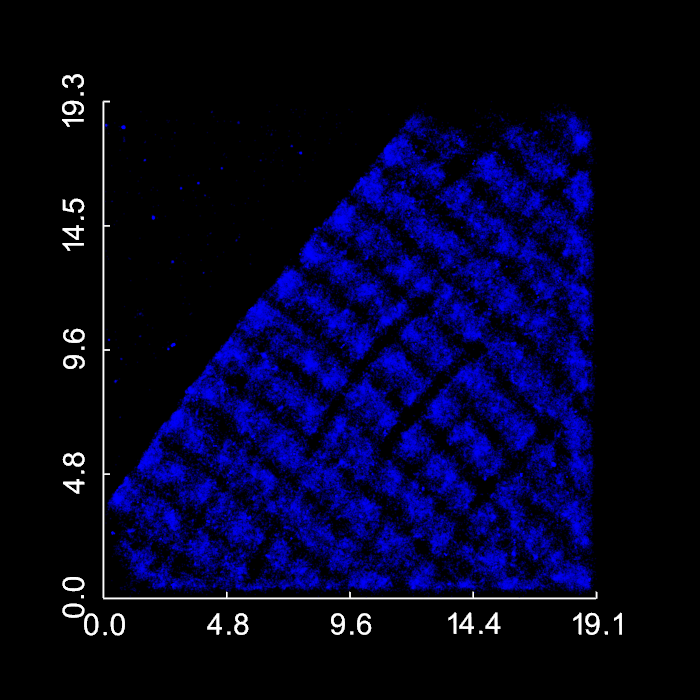

In [4]:
p = pv.Plotter(notebook=True, window_size=(700, 700))
point_cloud = pv.PolyData(out[1].select(["x", "y", "z"]).to_numpy())
point_cloud = point_cloud.project_points_to_plane(origin=[0, 0, 0], normal=[0, 0, 1])
p.add_mesh(
    point_cloud,
    color="#FF0000",
    style="points_gaussian",
    # emissive=True,
    point_size=1,
    opacity=0.0,
)
point_cloud = pv.PolyData(out[0].select(["x", "y", "z"]).to_numpy())
point_cloud = point_cloud.project_points_to_plane(origin=[0, 0, 0], normal=[0, 0, 1])
p.add_mesh(
    point_cloud,
    color="#0000FF",
    style="points_gaussian",
    # emissive=True,
    point_size=1,
    opacity=0.2,
)
p.set_background(color="black")
p.enable_parallel_projection()

p.view_xy()
axis = p.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
# axis.x_axis_label_visibility = False
# axis.y_axis_label_visibility = False
# p.camera.tight(padding=0.2)
p.show()
p.save_graphic("../figures/supp_fig_1/1d/actin.svg")

In [7]:
voros = [VoronoiAnalysis(o.select(["x", "y", "z"]).to_numpy()) for o in out]
voro_vols = [v.region_volumes for v in voros]

100%|██████████| 14957/14957 [00:03<00:00, 3807.69it/s]


In [8]:
def determine_threshold(localizations, n_trials: int = 10, seed: int = 0):
    rng = np.random.default_rng(seed)
    volumes = []
    for _ in tqdm(range(n_trials)):
        voro_rand = VoronoiAnalysis(random_uniform_like(localizations, rng))
        volumes.append(voro_rand.region_volumes)
    return volumes


voro_vol_rands = [determine_threshold(v.points) for v in voros]

100%|██████████| 10/10 [00:46<00:00,  4.63s/it]


In [9]:
voro_vol_rands_ = [np.stack(v, axis=0) for v in voro_vol_rands]
for v in voro_vol_rands_:
    print(v.shape)

(10, 284098)
(10, 14957)


In [28]:
savepath = datadir / f"results/{filepath.stem}_voronoi_volumes.npz"
if not savepath.exists():
    np.savez(
        savepath,
        actin=voro_vols[0],
        desmin=voro_vols[1],
        actin_random=voro_vol_rands_[0],
        desmin_random=voro_vol_rands_[1],
    )

In [13]:
voronoi_volumes = np.load(datadir / "results/actin_desmin_600nm_voronoi_volumes.npz")

In [15]:
def histogram_fixed_binsize(values, bin_size, min_value=0.0, max_value=np.inf):
    values_valid = values[~np.isnan(values)]
    values_valid = np.clip(values_valid, min_value, max_value)
    bins = np.arange(min_value, max_value, bin_size)
    return np.histogram(values_valid, bins)


def internal_division_point(x1, x2, y1, y2):
    return (y1 * x2 + y2 * x1) / (y1 + y2)


def find_crossing_points(x, y1, y2):
    y_diff = y1 - y2
    x_exact_crossing = x[np.flatnonzero(y_diff == 0)]

    ind_sign_change = np.flatnonzero(y_diff[:-1] * y_diff[1:] <= 0)
    print(ind_sign_change)
    x_interped_crossing = internal_division_point(
        x[ind_sign_change],
        x[ind_sign_change + 1],
        y_diff[ind_sign_change],
        -y_diff[ind_sign_change + 1],
    )
    x_crossing = np.concatenate((x_exact_crossing, x_interped_crossing), axis=0)
    return np.sort(x_crossing)

(5001,)
[1.21947623e-01 1.65952804e+00 5.78356352e+00 ... 9.92298029e-04
 0.00000000e+00 3.40948559e-11]
[   2   31   33 ... 4997 4998 4999]


/tmp/ipykernel_2623418/4061791813.py:9: RuntimeWarning: invalid value encountered in divide
  return (y1 * x2 + y2 * x1) / (y1 + y2)


(5001,)
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.38779498e-01
 3.96513850e-02 6.45133995e-13]
[  54  441  442 ... 4995 4996 4998]


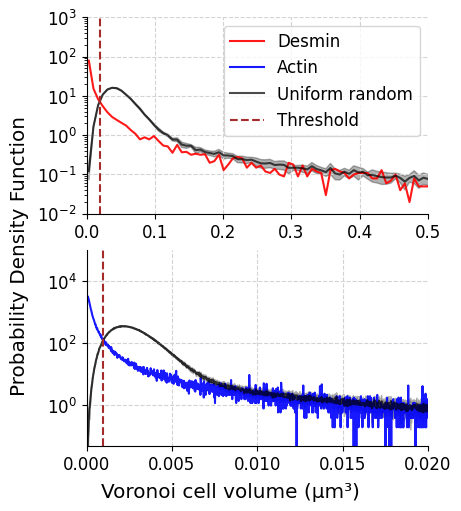

In [ ]:
vol_thresholds = []

fig, axes = plt.subplots(
    2,
    1,
    figsize=(4.5, 5),
    constrained_layout=True,
    # sharex=True,
    gridspec_kw={"wspace": 0.1},
)
names = ("desmin", "actin")
color_dict = {"desmin": "#FF0000", "actin": "#0000FF"}
title_dict = {"desmin": "Desmin", "actin": "Actin"}
for ax, n in zip(axes, names):
    volumes_all = np.concatenate(
        [voronoi_volumes[k].flatten() for k in (n, f"{n}_random")], axis=0
    )
    volumes_all = volumes_all[np.isfinite(volumes_all)]
    bin_edges = np.histogram_bin_edges(
        volumes_all[volumes_all <= np.percentile(volumes_all, 97.5)], bins=5000
    )
    bin_edges = np.concatenate((bin_edges, np.max(volumes_all, keepdims=True)), axis=0)
    counts = np.histogram(voronoi_volumes[n], bin_edges, density=True)[0]
    counts_rand = np.stack(
        [
            np.histogram(vol, bin_edges, density=True)[0]
            for vol in voronoi_volumes[f"{n}_random"]
        ],
        axis=0,
    )
    print(counts.shape)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.plot(bin_centers, counts, alpha=0.9, color=color_dict[n], label=title_dict[n])
    counts_rand_mean = np.mean(counts_rand, axis=0)
    ax = line_and_bandplot(
        ax,
        bin_centers,
        counts_rand_mean,
        np.std(counts_rand, axis=0),
        color="black",
        alpha=0.7,
        label="Uniform random",
    )
    ax.set_yscale("log")

    print(counts_rand_mean)
    vol_thres = find_crossing_points(bin_centers, counts, counts_rand_mean)[0]
    vol_thresholds.append(vol_thres)
    ax.axvline(x=vol_thres, linestyle="--", color="brown", label="Threshold")
    ax.grid(ls="--", color="lightgray")

l0, h0 = axes[0].get_legend_handles_labels()
l1, h1 = axes[1].get_legend_handles_labels()
# fig.legend([l0[0], *l1], [h0[0], *h1], loc="outside center right")
axes[0].legend([l0[0], *l1], [h0[0], *h1], loc="upper right")

axes[0].set_xlim((0, 0.5))
axes[-1].set_xlim((0, 0.02))
axes[0].set_ylim((1e-2, 1e3))
axes[1].set_ylim((5e-2, 1e5))
fig.supxlabel("Voronoi cell volume (μm³)", fontsize="large")
fig.supylabel("Probability Density Function", fontsize="large")
fig.savefig("../figures/supp_fig_1f.svg", dpi=500)

[  4  46  47  51  52  67  68  97  98  99 100 101 118 119 140 141 147 148
 162 163 169 170 177 178 181 182 195 196 207 208 209 210 231 232 234 235
 239 240 276 277]
[ 86  87  89  90  93  94  95  97  98 104 105]


Text(0.5, 0.01, 'Voronoi cell volume (μm³)')

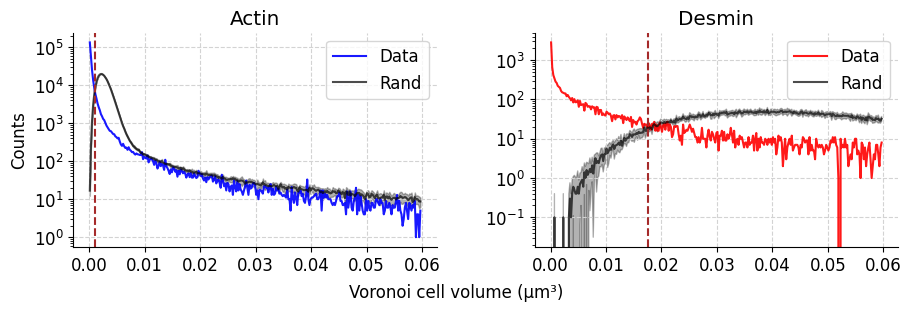

In [ ]:
vol_thresholds = {}

fig, axes = plt.subplots(
    1, 2, figsize=(9, 3), constrained_layout=True, gridspec_kw={"wspace": 0.1}
)
names = ("actin", "desmin")
color_dict = {"desmin": "red", "actin": "blue"}
title_dict = {"desmin": "Desmin", "actin": "Actin"}
for ax, n in zip(axes, names):
    counts, bin_edges = histogram_fixed_binsize(
        voronoi_volumes[n], bin_size=2e-4, max_value=6e-2
    )
    counts_rand = np.stack(
        [
            histogram_fixed_binsize(vol, bin_size=2e-4, max_value=6e-2)[0]
            for vol in voronoi_volumes[f"{n}_random"]
        ],
        axis=0,
    )
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.plot(bin_centers, counts, alpha=0.9, color=color_dict[n], label="Data")
    counts_rand_mean = np.mean(counts_rand, axis=0)
    ax = line_and_bandplot(
        ax,
        bin_centers,
        counts_rand_mean,
        np.std(counts_rand, axis=0),
        color="black",
        alpha=0.7,
        label="Rand",
    )
    ax.set_yscale("log")

    vol_thres = find_crossing_points(bin_centers, counts, counts_rand_mean)[0]
    vol_thresholds[n] = vol_thres
    ax.axvline(
        x=vol_thres,
        linestyle="--",
        color="brown",
    )
    ax.legend()
    ax.grid(ls="--", color="lightgray")
    ax.set_title(title_dict[n])
axes[0].set_ylabel("Counts")
fig.supxlabel("Voronoi cell volume (μm³)", fontsize="medium")

In [40]:
vol_thresholds

{'actin': np.float64(0.0009902164531469478),
 'desmin': np.float64(0.01748684210526316)}

In [41]:
df_filtered = [
    pl.concat(
        (
            out[i],
            pl.DataFrame({"voronoi_volume": voronoi_volumes[n]}),
        ),
        how="horizontal",
    ).filter(pl.col("voronoi_volume") <= vol_thresholds[n])
    for i, n in enumerate(("actin", "desmin"))
]
df_filtered_total = pl.concat(df_filtered)

In [42]:
savepath_filtered = datadir / f"results/{filepath.stem}_filtered.csv"
if not savepath_filtered.exists():
    df_filtered_total.write_csv(savepath_filtered)

In [43]:
df = pl.read_csv(datadir / "results/actin_desmin_600nm_filtered.csv")
out = df.partition_by("probe")

(array([4.0232e+04, 6.7537e+04, 7.3989e+04, 4.1309e+04, 1.1611e+04,
        2.1840e+03, 5.2800e+02, 2.7200e+02, 1.2700e+02, 1.9000e+01]),
 array([3.00430358, 3.35917562, 3.71404765, 4.06891969, 4.42379173,
        4.77866377, 5.1335358 , 5.48840784, 5.84327988, 6.19815192,
        6.55302396]),
 <BarContainer object of 10 artists>)

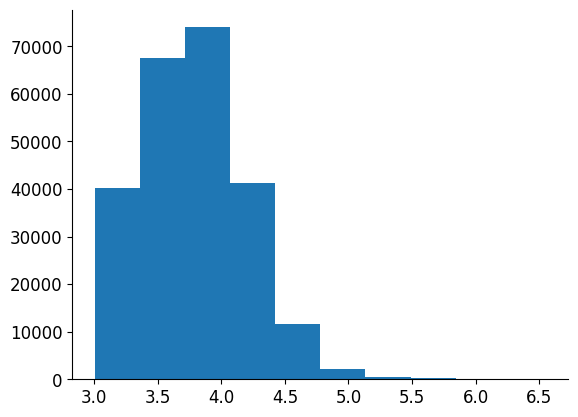

In [31]:
plt.hist(
    np.log10(1 / out[0]["voronoi_volume"]),
)

Text(0.5, 0.01, 'x (μm)')

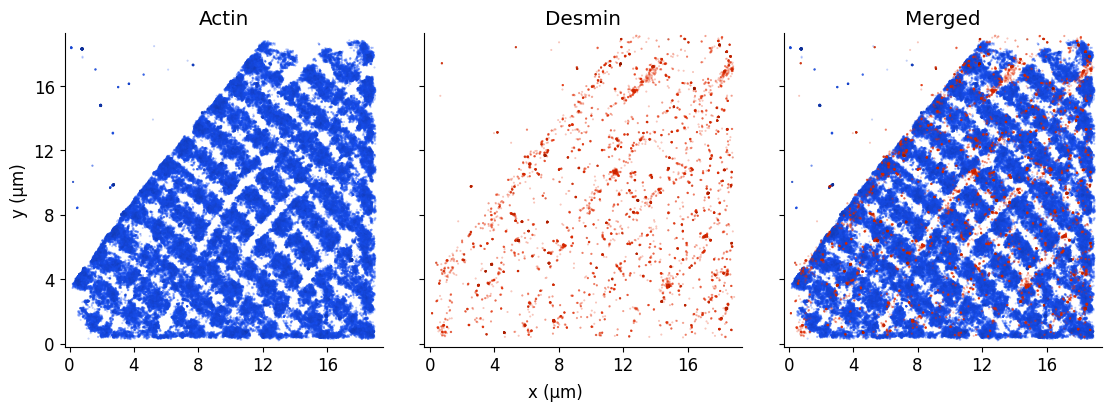

In [44]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2, "edgecolor": None, "vmax": 9, "vmin": 3.0}

fig, axes = plt.subplots(
    1,
    3,
    figsize=(11, 4),
    sharey=True,
    constrained_layout=True,
    gridspec_kw={"wspace": 0.1},
)
for i in (0, 2):
    axes[i].scatter(
        out[0]["x"],
        out[0]["y"],
        c=np.log10(1 / out[0]["voronoi_volume"]),
        cmap=cc.cm.kb_r,
        **scatter_kwargs,
    )
for i in (1, 2):
    axes[i].scatter(
        out[1]["x"],
        out[1]["y"],
        c=np.log10(1 / out[1]["voronoi_volume"]),
        cmap=cc.cm.kr_r,
        **scatter_kwargs,
    )

for ax, title in zip(axes, ("Actin", "Desmin", "Merged")):
    ax.axis("equal")
    # ax.set_xlim((-0.2, 19.3))
    ax.set_ylim((-0.2, 19.3))
    ax.set_xticks(np.arange(0, 20, 4))
    ax.set_yticks(np.arange(0, 20, 4))
    ax.set_title(title)
axes[0].set_ylabel("y (μm)")
fig.supxlabel("x (μm)", fontsize="medium")

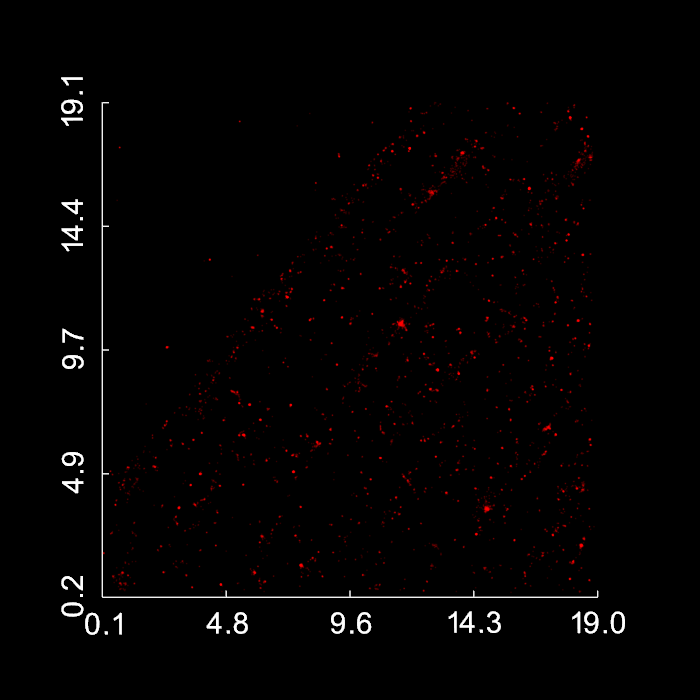

In [47]:
p = pv.Plotter(notebook=True, window_size=(700, 700))
point_cloud = pv.PolyData(out[1].select(["x", "y", "z"]).to_numpy())
point_cloud = point_cloud.project_points_to_plane(origin=[0, 0, 0], normal=[0, 0, 1])
p.add_mesh(
    point_cloud,
    color="#FF0000",
    style="points_gaussian",
    # emissive=True,
    point_size=1,
    opacity=0.2,
)
point_cloud = pv.PolyData(out[0].select(["x", "y", "z"]).to_numpy())
point_cloud = point_cloud.project_points_to_plane(origin=[0, 0, 0], normal=[0, 0, 1])
p.add_mesh(
    point_cloud,
    color="#0000FF",
    style="points_gaussian",
    # emissive=True,
    point_size=1,
    opacity=0.0,
)
p.set_background(color="black")
p.enable_parallel_projection()

p.view_xy()
axis = p.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
# axis.x_axis_label_visibility = False
# axis.y_axis_label_visibility = False
# p.camera.tight(padding=0.2)
p.show()
p.save_graphic("../figures/supp_fig_1/1e/desmin.svg")